In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

In [2]:
def produced_products(capacity):
    # Sets and Indices
    suppliers = ['A', 'B', 'C', 'D', 'E']           #Set of suppliers
    products = ['18/10', '18/8', '18/0']            #Set of products
    months = range(1, 13)                           #Set of months
    
    # Input Parameters
    cost = {'A': 5, 'B': 10, 'C': 9, 'D': 7, 'E': 8.5}                  #Cost / kg of scrap material from each supplier
    max_supply = {'A': 90, 'B': 30, 'C': 50, 'D': 70, 'E': 20}          #Maximum supply of scrap material per month from each supplier
    composition = {                                                     #Percentage of each element in the scrap material from each supplier
        'A': {'Chromium': 0.18, 'Nickel': 0.00, 'Copper': 0.00},
        'B': {'Chromium': 0.25, 'Nickel': 0.15, 'Copper': 0.04},
        'C': {'Chromium': 0.15, 'Nickel': 0.10, 'Copper': 0.02},
        'D': {'Chromium': 0.14, 'Nickel': 0.16, 'Copper': 0.05},
        'E': {'Chromium': 0.00, 'Nickel': 0.10, 'Copper': 0.03}
    }
    required_chromium = {"18/10": 0.18, "18/8": 0.18, "18/0": 0.18}     #Required percentage of Chromium for each product
    required_nickel = {'18/10': 0.10, '18/8': 0.08, '18/0': 0}          #Required percentage of Nickel for each product
    demand = {                                                          #Demand for each product each month
        1: {'18/10': 25, '18/8': 10, '18/0': 5},
        2: {'18/10': 25, '18/8': 10, '18/0': 20},
        3: {'18/10': 0, '18/8': 10, '18/0': 80},
        4: {'18/10': 0, '18/8': 10, '18/0': 25},
        5: {'18/10': 0, '18/8': 10, '18/0': 50},
        6: {'18/10': 50, '18/8': 10, '18/0': 125},
        7: {'18/10': 12, '18/8': 10, '18/0': 150},
        8: {'18/10': 0, '18/8': 10, '18/0': 80},
        9: {'18/10': 10, '18/8': 10, '18/0': 40},
        10: {'18/10': 10, '18/8': 10, '18/0': 35},
        11: {'18/10': 45, '18/8': 10, '18/0': 3},
        12: {'18/10': 99, '18/8': 10, '18/0': 100}
    }
    # demand ={                                                         #Testing Demand 10, 10, 10 for in January
    #     1: {'18/10': 10, '18/8': 10, '18/0': 10},
    #     2: {'18/10': 0, '18/8': 0, '18/0': 0},
    #     3: {'18/10': 0, '18/8': 0, '18/0': 0},
    #     4: {'18/10': 0, '18/8': 0, '18/0': 0},
    #     5: {'18/10': 0, '18/8': 0, '18/0': 0},
    #     6: {'18/10': 0, '18/8': 0, '18/0': 0},
    #     7: {'18/10': 0, '18/8': 0, '18/0': 0},
    #     8: {'18/10': 0, '18/8': 0, '18/0': 0},
    #     9: {'18/10': 0, '18/8': 0, '18/0': 0},
    #     10: {'18/10': 0, '18/8': 0, '18/0': 0},
    #     11: {'18/10': 0, '18/8': 0, '18/0': 0},
    #     12: {'18/10': 0, '18/8': 0, '18/0': 0}
    # }
    holding_cost = {'18/10': 20, '18/8': 10, '18/0': 5}                 #Holding cost per kg for each product
    #production_capacity = 100                                           #Total production capacity of all combined products each month
    
    # Create a new model
    model = gp.Model("StainlessSteelProduction")
    
    # Generate decision variables
    x = model.addVars(suppliers, products, months, name="x", vtype=GRB.CONTINUOUS, lb=0)
    y = model.addVars(products, months, name="y", vtype=GRB.CONTINUOUS, lb=0)
    z = model.addVars(products, months, name="z", vtype=GRB.CONTINUOUS, lb=0)
    
    #Sets
    I = range(len(suppliers))        #Set of suppliers
    J = range(len(products))         #Set of products
    M = months                       #Set of months
    
    # (1) Objective function: Minimize the total cost
    model.setObjective(
        gp.quicksum(cost[i] * x[i, j, m] for i in suppliers for j in products for m in months) +
        gp.quicksum(holding_cost[j] * z[j, m] for j in products for m in months),
        GRB.MINIMIZE
    )
    
    # Subject to some constraints
    # (2) Supply constraints that cannot be exceeded by each supplier
    for i in suppliers:
        for m in months:
            model.addConstr(gp.quicksum(x[i, j, m] for j in products) <= max_supply[i], name=f"Supply_{i}_{m}")
    
    # (3) Production capacity constraints for each month
    for m in months:
        model.addConstr(gp.quicksum(y[j, m] for j in products) <= capacity, name=f"Capacity_{m}")
    
    # (4) Demand satisfaction constraints for each month including the products in stock
    for j in products:
        for m in months:
            if m == 1:
                model.addConstr(y[j, m] == demand[m][j] + z[j, m], name=f"Demand_{j}_{m}")
            else:
                model.addConstr(y[j, m] + z[j, m-1] == demand[m][j] + z[j, m], name=f"Demand_{j}_{m}")
    
    # (5) The composition required for production for Chromium
    for j in products:
        for m in months:
            model.addConstr(gp.quicksum(composition[i]["Chromium"] * x[i,j,m] for i in suppliers) ==
                            required_chromium[j] * y[j,m],
                            name = f"Chromium_unmixing_{j}_{m}")
    
    # (6) The composition required for production for Nickel
    for j in products:
        for m in months:
            model.addConstr(gp.quicksum(composition[i]["Nickel"] * x[i,j,m] for i in suppliers) ==
                            required_nickel[j] * y[j,m],
                            name = f"Nickel_unmixing_{j}_{m}")
    
    # (7) No scrap material can be stored/wasted
    for m in months:
        model.addConstr(gp.quicksum(x[i,j,m] for i in suppliers for j in products) == gp.quicksum(y[j,m] for j in products))
    
    # (8) Non-negativity constraints are implicitly handled by the variable definitions
    
    # Trial from Airplane Cargo Example
    model.setParam( 'OutputFlag', True) # silencing gurobi output or not
    model.setParam ('MIPGap', 0);       # find the optimal solution
    model.write("output.lp")            # print the model in .lp format file
    
    # Optimize the model
    model.optimize()

    produced_product_C = []
    for m in M:
        # print('\nMonth %d' % (m))
        produced_product_C.append(z["18/0", m].X)

        # print('%s production: %8.3f' % ("18/0", y["18/0", m].X))
        # print('%s storage: %8.3f' % ("18/0", z["18/0", m].X))

    return produced_product_C

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-20
Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 192 rows, 252 columns and 885 nonzeros
Model fingerprint: 0x8170d707
Coefficient statistics:
  Matrix range     [8e-02, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 52 rows and 88 columns
Presolve time: 0.02s
Presolved: 140 rows, 164 columns, 667 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2496800e+03   7.356643e+02   0.000000e+00      0s
      86    1.0250349e+04   0.000000e+00   0.000000e+00      0s

Solved in 86 iterations and 0.03 seconds (0.00 work units)
Optimal objective 

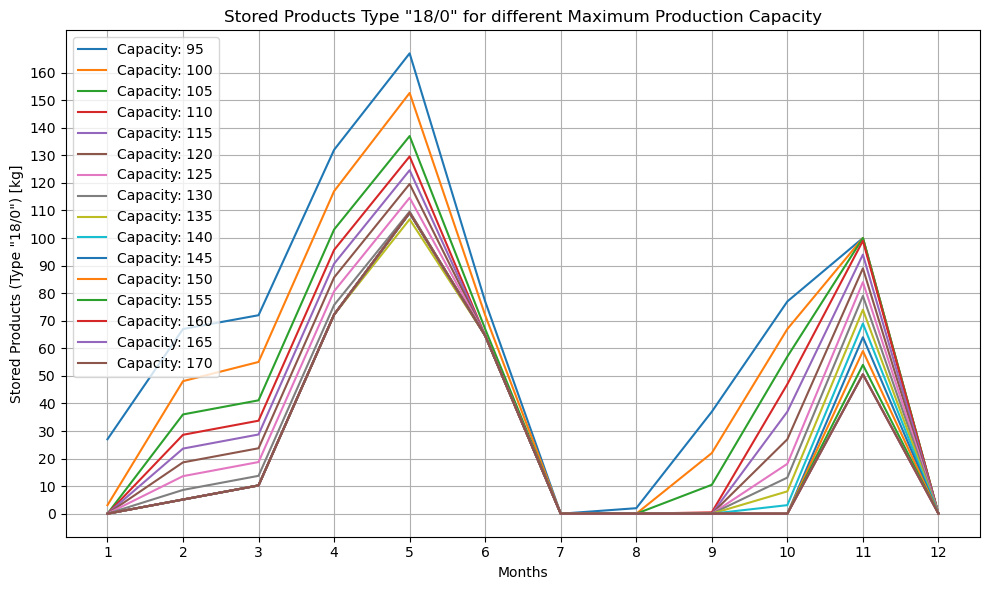

In [3]:
# capacity_range = [100]
capacity_range = range(95, 171, 5)

produced_products_C = [produced_products(capacity) for capacity in capacity_range]
print(produced_products_C)

# Plot the results for produced products vs capacity
plt.figure(figsize=(10, 6))
for i, capacity in enumerate(capacity_range):
    plt.plot(range(1, 13), produced_products_C[i], label=f"Capacity: {capacity}")

plt.title('Stored Products Type "18/0" for different Maximum Production Capacity')
plt.xlabel('Months')
plt.ylabel('Stored Products (Type "18/0") [kg]')
plt.xticks(ticks=range(1, 13), labels=[f'{i}' for i in range(1, 13)])
plt.yticks(np.arange(0, max(max(produced_products_C)), 10))  # Adjust max range dynamically based on the data
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('stored_products_vs_capacity.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 192 rows, 252 columns and 885 nonzeros
Model fingerprint: 0xdbe1bf75
Coefficient statistics:
  Matrix range     [8e-02, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 52 rows and 88 columns
Presolve time: 0.01s
Presolved: 140 rows, 164 columns, 667 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.1696800e+03   7.371343e+02   0.000000e+00      0s
      86    1.0835349e+04   0.000000e+00   0.000000e+00      0s

Solved in 86 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.083534884e+04
Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.

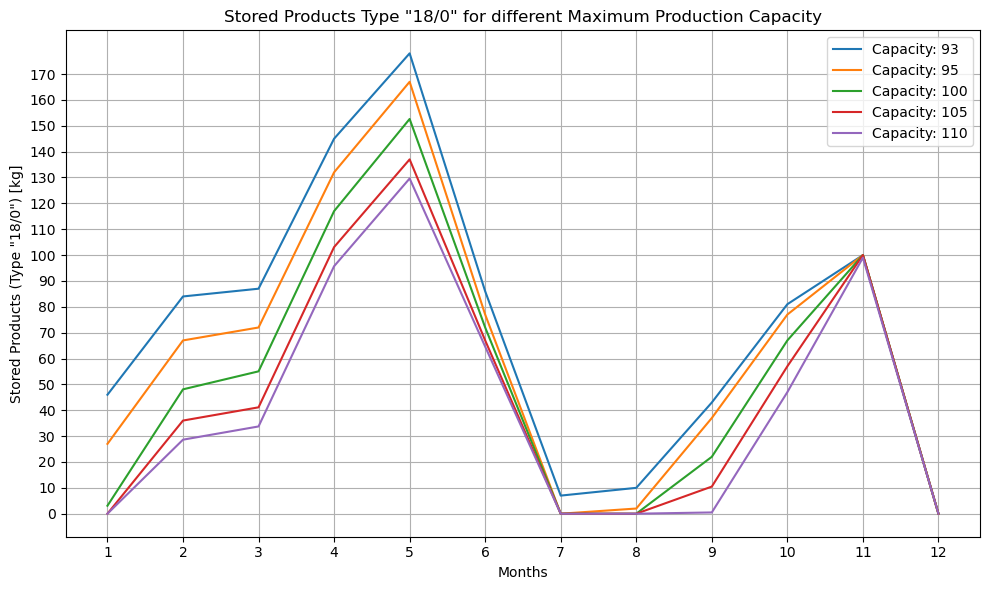

In [4]:
capacity_range = [93, 95, 100, 105, 110]
# capacity_range = range(95, 171, 5)

produced_products_C = [produced_products(capacity) for capacity in capacity_range]
print(produced_products_C)

# Plot the results for produced products vs capacity
plt.figure(figsize=(10, 6))
for i, capacity in enumerate(capacity_range):
    plt.plot(range(1, 13), produced_products_C[i], label=f"Capacity: {capacity}")

plt.title('Stored Products Type "18/0" for different Maximum Production Capacity')
plt.xlabel('Months')
plt.ylabel('Stored Products (Type "18/0") [kg]')
plt.xticks(ticks=range(1, 13), labels=[f'{i}' for i in range(1, 13)])
plt.yticks(np.arange(0, max(max(produced_products_C)), 10))  # Adjust max range dynamically based on the data
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('stored_products_vs_capacity 93 until 110.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 192 rows, 252 columns and 885 nonzeros
Model fingerprint: 0x44649f0c
Coefficient statistics:
  Matrix range     [8e-02, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 52 rows and 88 columns
Presolve time: 0.02s
Presolved: 140 rows, 164 columns, 667 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.7074000e+03   6.511801e+02   0.000000e+00      0s
      86    8.7742690e+03   0.000000e+00   0.000000e+00      0s

Solved in 86 iterations and 0.04 seconds (0.00 work units)
Optimal objective  8.774268959e+03
Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.

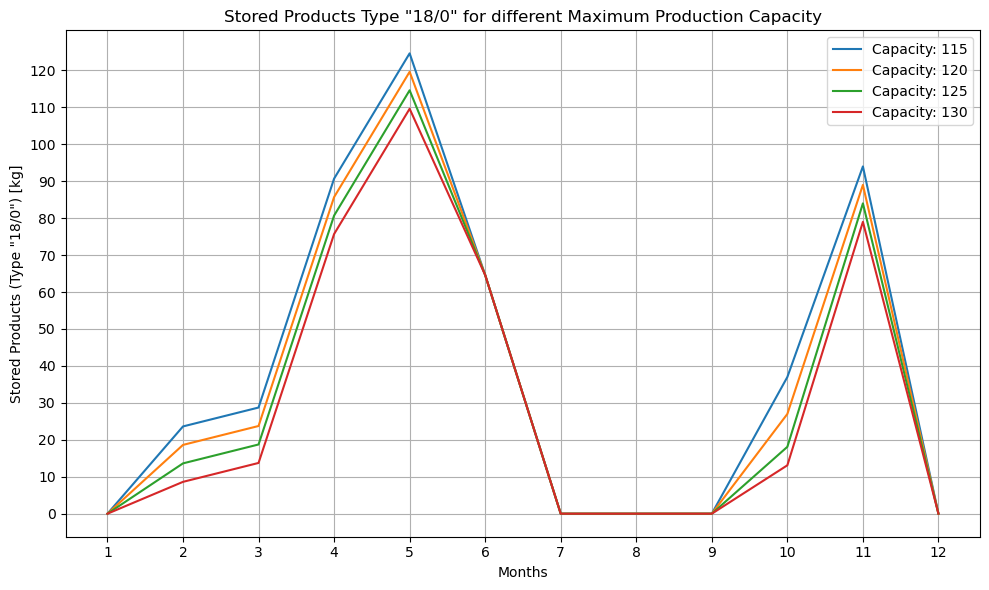

In [5]:
capacity_range = [115, 120, 125, 130]
# capacity_range = range(95, 171, 5)

produced_products_C = [produced_products(capacity) for capacity in capacity_range]
print(produced_products_C)

# Plot the results for produced products vs capacity
plt.figure(figsize=(10, 6))
for i, capacity in enumerate(capacity_range):
    plt.plot(range(1, 13), produced_products_C[i], label=f"Capacity: {capacity}")

plt.title('Stored Products Type "18/0" for different Maximum Production Capacity')
plt.xlabel('Months')
plt.ylabel('Stored Products (Type "18/0") [kg]')
plt.xticks(ticks=range(1, 13), labels=[f'{i}' for i in range(1, 13)])
plt.yticks(np.arange(0, max(max(produced_products_C)), 10))  # Adjust max range dynamically based on the data
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('stored_products_vs_capacity 115 until 130.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 192 rows, 252 columns and 885 nonzeros
Model fingerprint: 0xaa64e508
Coefficient statistics:
  Matrix range     [8e-02, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 52 rows and 88 columns
Presolve time: 0.02s
Presolved: 140 rows, 164 columns, 667 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.3074000e+03   6.432801e+02   0.000000e+00      0s
      94    8.2298001e+03   0.000000e+00   0.000000e+00      0s

Solved in 94 iterations and 0.03 seconds (0.00 work units)
Optimal objective  8.229800114e+03
Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.

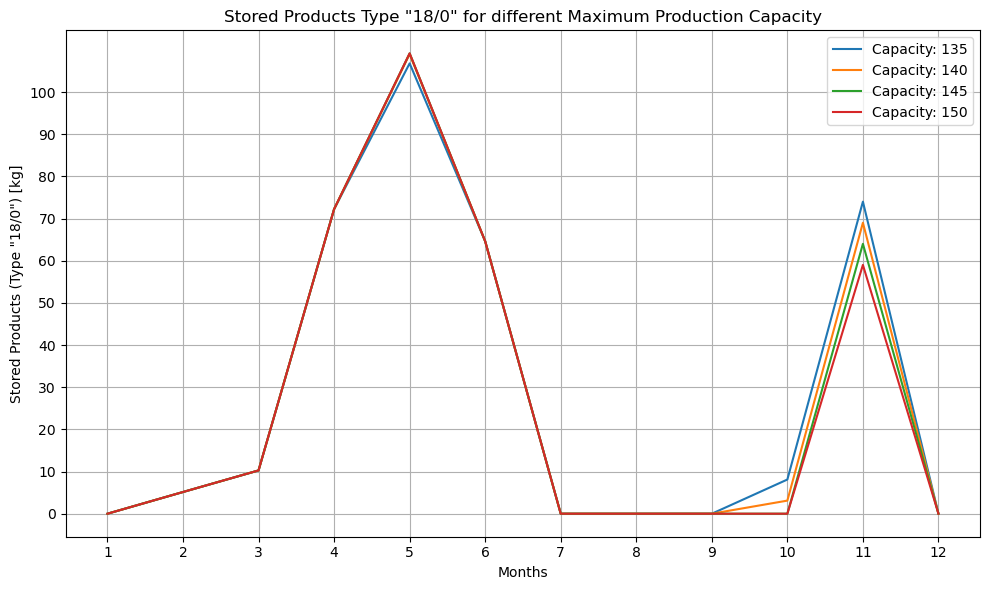

In [6]:
capacity_range = [135, 140, 145, 150]
# capacity_range = range(95, 171, 5)

produced_products_C = [produced_products(capacity) for capacity in capacity_range]
print(produced_products_C)

# Plot the results for produced products vs capacity
plt.figure(figsize=(10, 6))
for i, capacity in enumerate(capacity_range):
    plt.plot(range(1, 13), produced_products_C[i], label=f"Capacity: {capacity}")

plt.title('Stored Products Type "18/0" for different Maximum Production Capacity')
plt.xlabel('Months')
plt.ylabel('Stored Products (Type "18/0") [kg]')
plt.xticks(ticks=range(1, 13), labels=[f'{i}' for i in range(1, 13)])
plt.yticks(np.arange(0, max(max(produced_products_C)), 10))  # Adjust max range dynamically based on the data
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('stored_products_vs_capacity 135 until 150.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 192 rows, 252 columns and 885 nonzeros
Model fingerprint: 0xf92797a2
Coefficient statistics:
  Matrix range     [8e-02, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 52 rows and 88 columns
Presolve time: 0.02s
Presolved: 140 rows, 164 columns, 667 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.9074000e+03   6.353801e+02   0.000000e+00      0s
      94    8.0230404e+03   0.000000e+00   0.000000e+00      0s

Solved in 94 iterations and 0.03 seconds (0.00 work units)
Optimal objective  8.023040445e+03
Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.

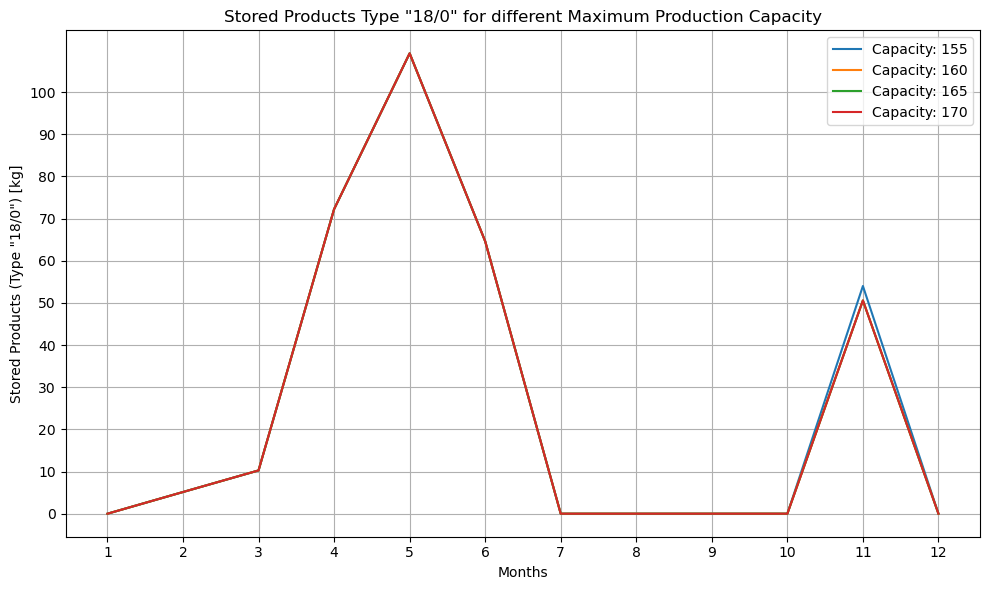

In [7]:
capacity_range = [155, 160, 165, 170]
# capacity_range = range(95, 171, 5)

produced_products_C = [produced_products(capacity) for capacity in capacity_range]
print(produced_products_C)

# Plot the results for produced products vs capacity
plt.figure(figsize=(10, 6))
for i, capacity in enumerate(capacity_range):
    plt.plot(range(1, 13), produced_products_C[i], label=f"Capacity: {capacity}")

plt.title('Stored Products Type "18/0" for different Maximum Production Capacity')
plt.xlabel('Months')
plt.ylabel('Stored Products (Type "18/0") [kg]')
plt.xticks(ticks=range(1, 13), labels=[f'{i}' for i in range(1, 13)])
plt.yticks(np.arange(0, max(max(produced_products_C)), 10))  # Adjust max range dynamically based on the data
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('stored_products_vs_capacity 155 until 170.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [48]:
def stored_products(hol_cost):
    # Sets and Indices
    suppliers = ['A', 'B', 'C', 'D', 'E']           #Set of suppliers
    products = ['18/10', '18/8', '18/0']            #Set of products
    months = range(1, 13)                           #Set of months
    
    # Input Parameters
    cost = {'A': 5, 'B': 10, 'C': 9, 'D': 7, 'E': 8.5}                  #Cost / kg of scrap material from each supplier
    max_supply = {'A': 90, 'B': 30, 'C': 50, 'D': 70, 'E': 20}          #Maximum supply of scrap material per month from each supplier
    composition = {                                                     #Percentage of each element in the scrap material from each supplier
        'A': {'Chromium': 0.18, 'Nickel': 0.00, 'Copper': 0.00},
        'B': {'Chromium': 0.25, 'Nickel': 0.15, 'Copper': 0.04},
        'C': {'Chromium': 0.15, 'Nickel': 0.10, 'Copper': 0.02},
        'D': {'Chromium': 0.14, 'Nickel': 0.16, 'Copper': 0.05},
        'E': {'Chromium': 0.00, 'Nickel': 0.10, 'Copper': 0.03}
    }
    required_chromium = {"18/10": 0.18, "18/8": 0.18, "18/0": 0.18}     #Required percentage of Chromium for each product
    required_nickel = {'18/10': 0.10, '18/8': 0.08, '18/0': 0}          #Required percentage of Nickel for each product
    demand = {                                                          #Demand for each product each month
        1: {'18/10': 25, '18/8': 10, '18/0': 5},
        2: {'18/10': 25, '18/8': 10, '18/0': 20},
        3: {'18/10': 0, '18/8': 10, '18/0': 80},
        4: {'18/10': 0, '18/8': 10, '18/0': 25},
        5: {'18/10': 0, '18/8': 10, '18/0': 50},
        6: {'18/10': 50, '18/8': 10, '18/0': 125},
        7: {'18/10': 12, '18/8': 10, '18/0': 150},
        8: {'18/10': 0, '18/8': 10, '18/0': 80},
        9: {'18/10': 10, '18/8': 10, '18/0': 40},
        10: {'18/10': 10, '18/8': 10, '18/0': 35},
        11: {'18/10': 45, '18/8': 10, '18/0': 3},
        12: {'18/10': 99, '18/8': 10, '18/0': 100}
    }
    # demand ={                                                         #Testing Demand 10, 10, 10 for in January
    #     1: {'18/10': 10, '18/8': 10, '18/0': 10},
    #     2: {'18/10': 0, '18/8': 0, '18/0': 0},
    #     3: {'18/10': 0, '18/8': 0, '18/0': 0},
    #     4: {'18/10': 0, '18/8': 0, '18/0': 0},
    #     5: {'18/10': 0, '18/8': 0, '18/0': 0},
    #     6: {'18/10': 0, '18/8': 0, '18/0': 0},
    #     7: {'18/10': 0, '18/8': 0, '18/0': 0},
    #     8: {'18/10': 0, '18/8': 0, '18/0': 0},
    #     9: {'18/10': 0, '18/8': 0, '18/0': 0},
    #     10: {'18/10': 0, '18/8': 0, '18/0': 0},
    #     11: {'18/10': 0, '18/8': 0, '18/0': 0},
    #     12: {'18/10': 0, '18/8': 0, '18/0': 0}
    # }
    holding_cost = {'18/10': 20, '18/8': 10, '18/0': hol_cost}                 #Holding cost per kg for each product
    production_capacity = 100                                           #Total production capacity of all combined products each month
    
    # Create a new model
    model = gp.Model("StainlessSteelProduction")
    
    # Generate decision variables
    x = model.addVars(suppliers, products, months, name="x", vtype=GRB.CONTINUOUS, lb=0)
    y = model.addVars(products, months, name="y", vtype=GRB.CONTINUOUS, lb=0)
    z = model.addVars(products, months, name="z", vtype=GRB.CONTINUOUS, lb=0)
    
    #Sets
    I = range(len(suppliers))        #Set of suppliers
    J = range(len(products))         #Set of products
    M = months                       #Set of months
    
    # (1) Objective function: Minimize the total cost
    model.setObjective(
        gp.quicksum(cost[i] * x[i, j, m] for i in suppliers for j in products for m in months) +
        gp.quicksum(holding_cost[j] * z[j, m] for j in products for m in months),
        GRB.MINIMIZE
    )
    
    # Subject to some constraints
    # (2) Supply constraints that cannot be exceeded by each supplier
    for i in suppliers:
        for m in months:
            model.addConstr(gp.quicksum(x[i, j, m] for j in products) <= max_supply[i], name=f"Supply_{i}_{m}")
    
    # (3) Production capacity constraints for each month
    for m in months:
        model.addConstr(gp.quicksum(y[j, m] for j in products) <= production_capacity, name=f"Capacity_{m}")
    
    # (4) Demand satisfaction constraints for each month including the products in stock
    for j in products:
        for m in months:
            if m == 1:
                model.addConstr(y[j, m] == demand[m][j] + z[j, m], name=f"Demand_{j}_{m}")
            else:
                model.addConstr(y[j, m] + z[j, m-1] == demand[m][j] + z[j, m], name=f"Demand_{j}_{m}")
    
    # (5) The composition required for production for Chromium
    for j in products:
        for m in months:
            model.addConstr(gp.quicksum(composition[i]["Chromium"] * x[i,j,m] for i in suppliers) ==
                            required_chromium[j] * y[j,m],
                            name = f"Chromium_unmixing_{j}_{m}")
    
    # (6) The composition required for production for Nickel
    for j in products:
        for m in months:
            model.addConstr(gp.quicksum(composition[i]["Nickel"] * x[i,j,m] for i in suppliers) ==
                            required_nickel[j] * y[j,m],
                            name = f"Nickel_unmixing_{j}_{m}")
    
    # (7) No scrap material can be stored/wasted
    for m in months:
        model.addConstr(gp.quicksum(x[i,j,m] for i in suppliers for j in products) == gp.quicksum(y[j,m] for j in products))
    
    # (8) Non-negativity constraints are implicitly handled by the variable definitions
    
    # Trial from Airplane Cargo Example
    model.setParam( 'OutputFlag', True) # silencing gurobi output or not
    model.setParam ('MIPGap', 0);       # find the optimal solution
    model.write("output.lp")            # print the model in .lp format file
    
    # Optimize the model
    model.optimize()

    produced_product_A = []
    produced_product_B = []
    produced_product_C = []
    for m in M:
        # print('\nMonth %d' % (m))
        produced_product_A.append(y["18/10", m].X)
        produced_product_B.append(y["18/8", m].X)
        produced_product_C.append(y["18/0", m].X)

        # print('%s production: %8.3f' % ("18/0", y["18/0", m].X))
        # print('%s storage: %8.3f' % ("18/0", z["18/0", m].X))

    return produced_product_A, produced_product_B, produced_product_C

Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 192 rows, 252 columns and 885 nonzeros
Model fingerprint: 0xafa8e8b6
Coefficient statistics:
  Matrix range     [8e-02, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 52 rows and 89 columns
Presolve time: 0.02s
Presolved: 140 rows, 163 columns, 666 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2918400e+03   6.666841e+02   0.000000e+00      0s
      84    6.3703488e+03   0.000000e+00   0.000000e+00      0s

Solved in 84 iterations and 0.03 seconds (0.00 work units)
Optimal objective  6.370348837e+03
Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.

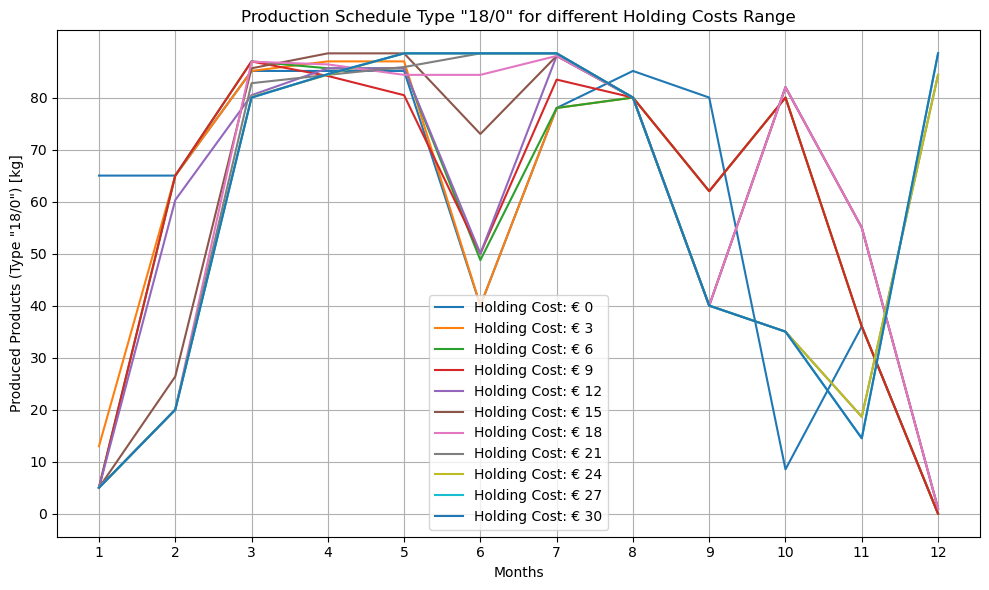

In [50]:
hol_cost_range = range(0, 31, 3)

stored_products_steel = [stored_products(hol_cost) for hol_cost in hol_cost_range]

stored_products_A = [stored_products_steel[i][0] for i in range(len(stored_products_steel))]
stored_products_B = [stored_products_steel[i][1] for i in range(len(stored_products_steel))]
stored_products_C = [stored_products_steel[i][2] for i in range(len(stored_products_steel))]

# print(stored_products_A)

# Plot the results for produced products vs capacity
plt.figure(figsize=(10, 6))
for i, hol_cost in enumerate(hol_cost_range):
    # plt.plot(range(1, 13), stored_products_A[i], label=f"Holding Cost: € {hol_cost}")
    # plt.plot(range(1, 13), stored_products_B[i], label=f"Holding Cost: € {hol_cost}")
    plt.plot(range(1, 13), stored_products_C[i], label=f"Holding Cost: € {hol_cost}")
    
plt.title('Production Schedule Type "18/0" for different Holding Costs Range')
plt.xlabel('Months')
plt.ylabel('Produced Products (Type "18/0") [kg]')
plt.xticks(ticks=range(1, 13), labels=[f'{i}' for i in range(1, 13)])
plt.yticks(np.arange(0, max(max(stored_products_C)), 10))  # Adjust max range dynamically based on the data
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('produced_products_vs_holding_costs_typeC.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 192 rows, 252 columns and 885 nonzeros
Model fingerprint: 0xafa8e8b6
Coefficient statistics:
  Matrix range     [8e-02, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 52 rows and 89 columns
Presolve time: 0.02s
Presolved: 140 rows, 163 columns, 666 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2918400e+03   6.666841e+02   0.000000e+00      0s
      84    6.3703488e+03   0.000000e+00   0.000000e+00      0s

Solved in 84 iterations and 0.04 seconds (0.00 work units)
Optimal objective  6.370348837e+03
Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.

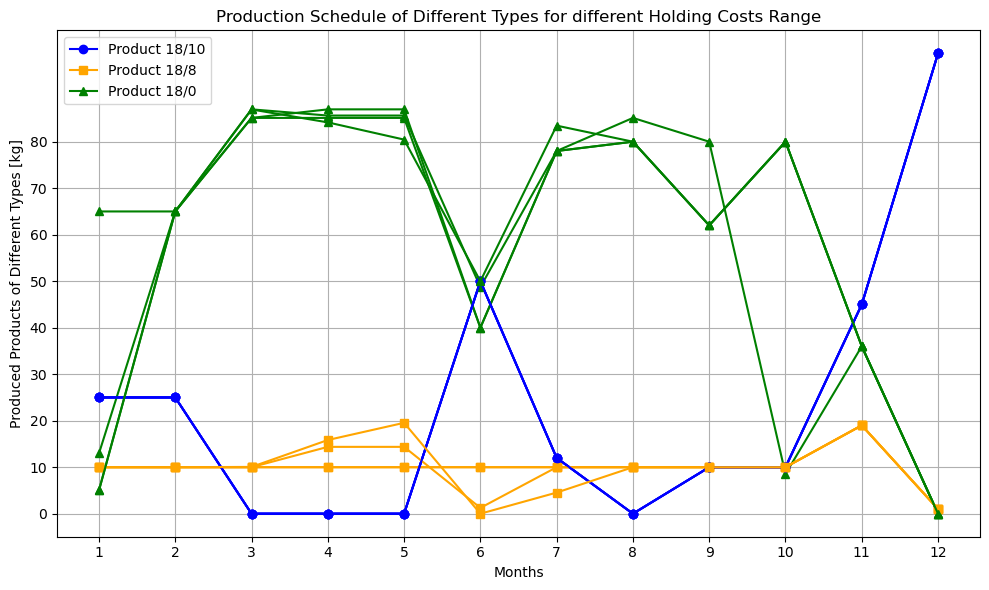

In [10]:
hol_cost_range = range(0, 10, 3)

stored_products_steel = [stored_products(hol_cost) for hol_cost in hol_cost_range]

stored_products_A = [stored_products_steel[i][0] for i in range(len(stored_products_steel))]
stored_products_B = [stored_products_steel[i][1] for i in range(len(stored_products_steel))]
stored_products_C = [stored_products_steel[i][2] for i in range(len(stored_products_steel))]

# Define colors and markers for each product type
colors = ['blue', 'orange', 'green']
markers = ['o', 's', '^']  # Circle, square, triangle
product_labels = ['Product 18/10', 'Product 18/8', 'Product 18/0']

# Plot the results for produced products vs capacity
plt.figure(figsize=(10, 6))

for i, hol_cost in enumerate(hol_cost_range):
    for j in range(3):  # Loop over product types
        plt.plot(range(1, 13), [stored_products_A, stored_products_B, stored_products_C][j][i],
                 color=colors[j], marker=markers[j],
                 label=product_labels[j] if i == 0 else "")

plt.title('Production Schedule of Different Types for different Holding Costs Range')
plt.xlabel('Months')
plt.ylabel('Produced Products of Different Types [kg]')
plt.xticks(ticks=range(1, 13), labels=[f'{i}' for i in range(1, 13)])
plt.yticks(np.arange(0, max(max(stored_products_C)), 10))
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig('produced_products_vs_holding_costs_0 to 9_typeC.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 192 rows, 252 columns and 885 nonzeros
Model fingerprint: 0x924a6c04
Coefficient statistics:
  Matrix range     [8e-02, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 52 rows and 88 columns
Presolve time: 0.02s
Presolved: 140 rows, 164 columns, 667 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.4391840e+03   6.132275e+02   0.000000e+00      0s
     100    1.3773542e+04   0.000000e+00   0.000000e+00      0s

Solved in 100 iterations and 0.03 seconds (0.00 work units)
Optimal objective  1.377354216e+04
Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11

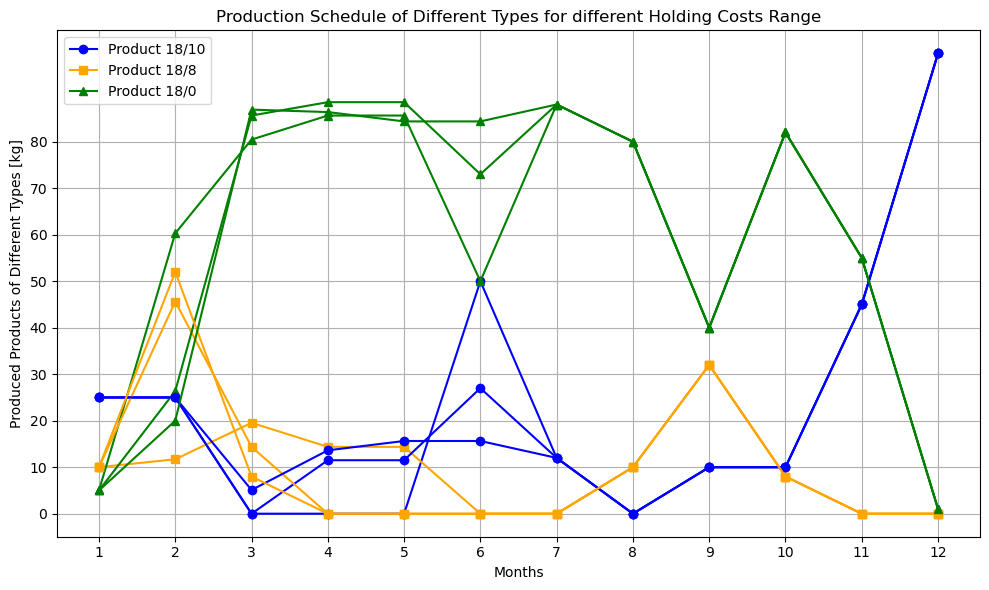

In [11]:
hol_cost_range = range(12, 19, 3)

stored_products_steel = [stored_products(hol_cost) for hol_cost in hol_cost_range]

stored_products_A = [stored_products_steel[i][0] for i in range(len(stored_products_steel))]
stored_products_B = [stored_products_steel[i][1] for i in range(len(stored_products_steel))]
stored_products_C = [stored_products_steel[i][2] for i in range(len(stored_products_steel))]

# Define colors and markers for each product type
colors = ['blue', 'orange', 'green']
markers = ['o', 's', '^']  # Circle, square, triangle
product_labels = ['Product 18/10', 'Product 18/8', 'Product 18/0']

# Plot the results for produced products vs capacity
plt.figure(figsize=(10, 6))

for i, hol_cost in enumerate(hol_cost_range):
    for j in range(3):  # Loop over product types
        plt.plot(range(1, 13), [stored_products_A, stored_products_B, stored_products_C][j][i],
                 color=colors[j], marker=markers[j],
                 label=product_labels[j] if i == 0 else "")

plt.title('Production Schedule of Different Types for different Holding Costs Range')
plt.xlabel('Months')
plt.ylabel('Produced Products of Different Types [kg]')
plt.xticks(ticks=range(1, 13), labels=[f'{i}' for i in range(1, 13)])
plt.yticks(np.arange(0, max(max(stored_products_C)), 10))
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig('produced_products_vs_holding_costs_12 to 18_typeC.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 192 rows, 252 columns and 885 nonzeros
Model fingerprint: 0xceb74feb
Coefficient statistics:
  Matrix range     [8e-02, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 52 rows and 88 columns
Presolve time: 0.02s
Presolved: 140 rows, 164 columns, 667 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.3871920e+03   6.132275e+02   0.000000e+00      0s
      93    1.7388305e+04   0.000000e+00   0.000000e+00      0s

Solved in 93 iterations and 0.03 seconds (0.00 work units)
Optimal objective  1.738830527e+04
Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.

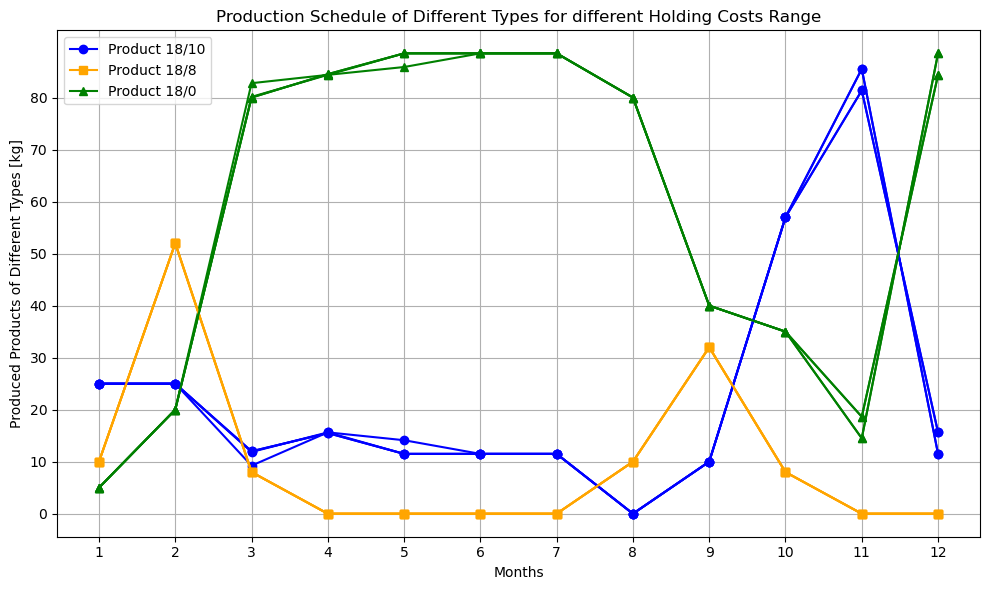

In [12]:
hol_cost_range = range(21, 31, 3)

stored_products_steel = [stored_products(hol_cost) for hol_cost in hol_cost_range]

stored_products_A = [stored_products_steel[i][0] for i in range(len(stored_products_steel))]
stored_products_B = [stored_products_steel[i][1] for i in range(len(stored_products_steel))]
stored_products_C = [stored_products_steel[i][2] for i in range(len(stored_products_steel))]

# Define colors and markers for each product type
colors = ['blue', 'orange', 'green']
markers = ['o', 's', '^']  # Circle, square, triangle
product_labels = ['Product 18/10', 'Product 18/8', 'Product 18/0']

# Plot the results for produced products vs capacity
plt.figure(figsize=(10, 6))

for i, hol_cost in enumerate(hol_cost_range):
    for j in range(3):  # Loop over product types
        plt.plot(range(1, 13), [stored_products_A, stored_products_B, stored_products_C][j][i],
                 color=colors[j], marker=markers[j],
                 label=product_labels[j] if i == 0 else "")

plt.title('Production Schedule of Different Types for different Holding Costs Range')
plt.xlabel('Months')
plt.ylabel('Produced Products of Different Types [kg]')
plt.xticks(ticks=range(1, 13), labels=[f'{i}' for i in range(1, 13)])
plt.yticks(np.arange(0, max(max(stored_products_C)), 10))
plt.grid(True)
plt.legend(loc = "upper left")
plt.tight_layout()
plt.savefig('produced_products_vs_holding_costs_21 to 30_typeC.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 192 rows, 252 columns and 885 nonzeros
Model fingerprint: 0xafa8e8b6
Coefficient statistics:
  Matrix range     [8e-02, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 52 rows and 89 columns
Presolve time: 0.01s
Presolved: 140 rows, 163 columns, 666 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -8.2918400e+03   6.666841e+02   0.000000e+00      0s
      84    6.3703488e+03   0.000000e+00   0.000000e+00      0s

Solved in 84 iterations and 0.02 seconds (0.00 work units)
Optimal objective  6.370348837e+03
Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.

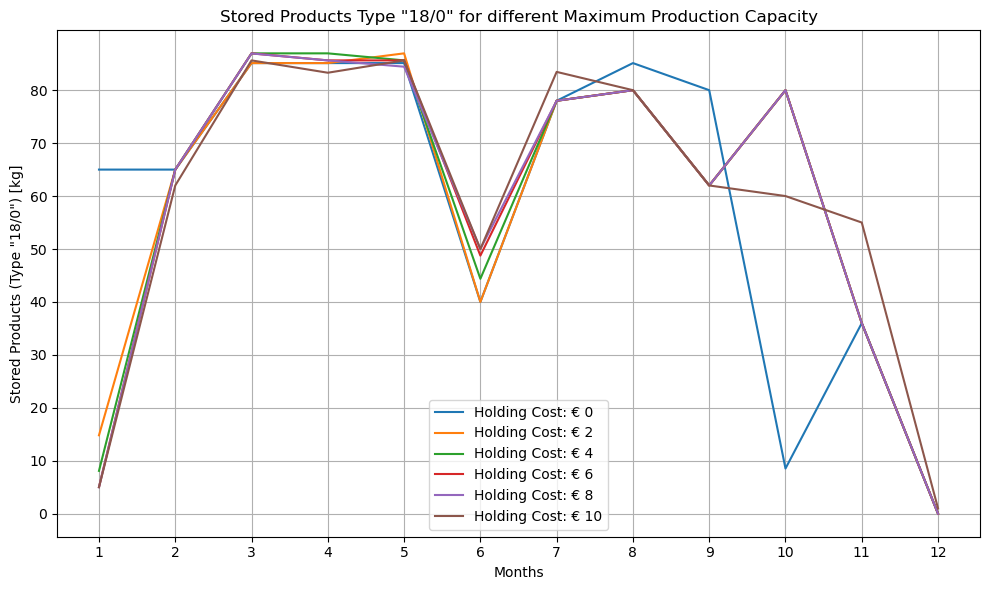

In [13]:
hol_cost_range = range(0, 11, 2)

stored_products_steel = [stored_products(hol_cost) for hol_cost in hol_cost_range]

stored_products_C = [stored_products_steel[i][2] for i in range(len(stored_products_steel))]
# print(stored_products_C)

# Plot the results for produced products vs capacity
plt.figure(figsize=(10, 6))
for i, hol_cost in enumerate(hol_cost_range):
    plt.plot(range(1, 13), stored_products_C[i], label=f"Holding Cost: € {hol_cost}")

plt.title('Stored Products Type "18/0" for different Maximum Production Capacity')
plt.xlabel('Months')
plt.ylabel('Stored Products (Type "18/0") [kg]')
plt.xticks(ticks=range(1, 13), labels=[f'{i}' for i in range(1, 13)])
plt.yticks(np.arange(0, max(max(stored_products_C)), 10))  # Adjust max range dynamically based on the data
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig('stored_products_vs_capacity.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 192 rows, 252 columns and 885 nonzeros
Model fingerprint: 0x924a6c04
Coefficient statistics:
  Matrix range     [8e-02, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 52 rows and 88 columns
Presolve time: 0.02s
Presolved: 140 rows, 164 columns, 667 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.4391840e+03   6.132275e+02   0.000000e+00      0s
     100    1.3773542e+04   0.000000e+00   0.000000e+00      0s

Solved in 100 iterations and 0.04 seconds (0.00 work units)
Optimal objective  1.377354216e+04
Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11

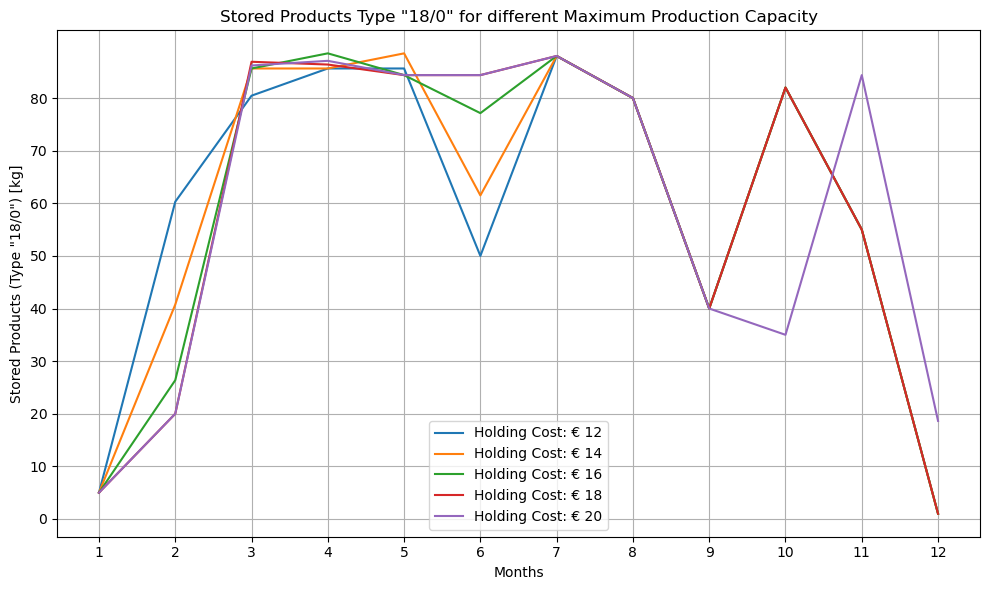

In [14]:
hol_cost_range = range(12, 21, 2)

stored_products_steel = [stored_products(hol_cost) for hol_cost in hol_cost_range]

stored_products_A = [stored_products_steel[i][0] for i in range(len(stored_products_steel))]
stored_products_B = [stored_products_steel[i][1] for i in range(len(stored_products_steel))]
stored_products_C = [stored_products_steel[i][2] for i in range(len(stored_products_steel))]
# print(stored_products_C[i][2])

# print(stored_products_C)

# Plot the results for produced products vs capacity
plt.figure(figsize=(10, 6))
for i, hol_cost in enumerate(hol_cost_range):
    plt.plot(range(1, 13), stored_products_C[i], label=f"Holding Cost: € {hol_cost}")

plt.title('Stored Products Type "18/0" for different Maximum Production Capacity')
plt.xlabel('Months')
plt.ylabel('Stored Products (Type "18/0") [kg]')
plt.xticks(ticks=range(1, 13), labels=[f'{i}' for i in range(1, 13)])
plt.yticks(np.arange(0, max(max(stored_products_C)), 10))  # Adjust max range dynamically based on the data
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig('stored_products_vs_capacity.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 192 rows, 252 columns and 885 nonzeros
Model fingerprint: 0x924a6c04
Coefficient statistics:
  Matrix range     [8e-02, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 52 rows and 88 columns
Presolve time: 0.01s
Presolved: 140 rows, 164 columns, 667 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.4391840e+03   6.132275e+02   0.000000e+00      0s
     100    1.3773542e+04   0.000000e+00   0.000000e+00      0s

Solved in 100 iterations and 0.03 seconds (0.00 work units)
Optimal objective  1.377354216e+04
Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11

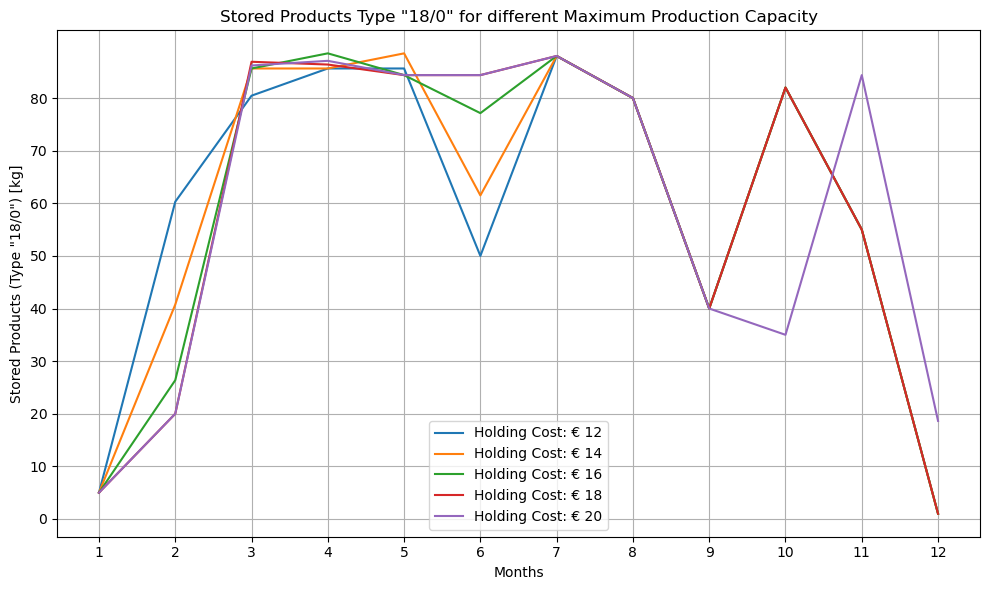

In [15]:
hol_cost_range = range(12, 21, 2)

stored_products_steel = [stored_products(hol_cost) for hol_cost in hol_cost_range]

stored_products_A = [stored_products_steel[i][0] for i in range(len(stored_products_steel))]
stored_products_B = [stored_products_steel[i][1] for i in range(len(stored_products_steel))]
stored_products_C = [stored_products_steel[i][2] for i in range(len(stored_products_steel))]

# Plot the results for produced products vs capacity
plt.figure(figsize=(10, 6))
for i, hol_cost in enumerate(hol_cost_range):
    plt.plot(range(1, 13), stored_products_C[i], label=f"Holding Cost: € {hol_cost}")

plt.title('Stored Products Type "18/0" for different Maximum Production Capacity')
plt.xlabel('Months')
plt.ylabel('Stored Products (Type "18/0") [kg]')
plt.xticks(ticks=range(1, 13), labels=[f'{i}' for i in range(1, 13)])
plt.yticks(np.arange(0, max(max(stored_products_C)), 10))  # Adjust max range dynamically based on the data
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig('stored_products_vs_capacity.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 192 rows, 252 columns and 885 nonzeros
Model fingerprint: 0x0a161b52
Coefficient statistics:
  Matrix range     [8e-02, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 52 rows and 88 columns
Presolve time: 0.01s
Presolved: 140 rows, 164 columns, 667 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.2703040e+03   6.132275e+02   0.000000e+00      0s
      92    1.7628333e+04   0.000000e+00   0.000000e+00      0s

Solved in 92 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.762833254e+04
Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.

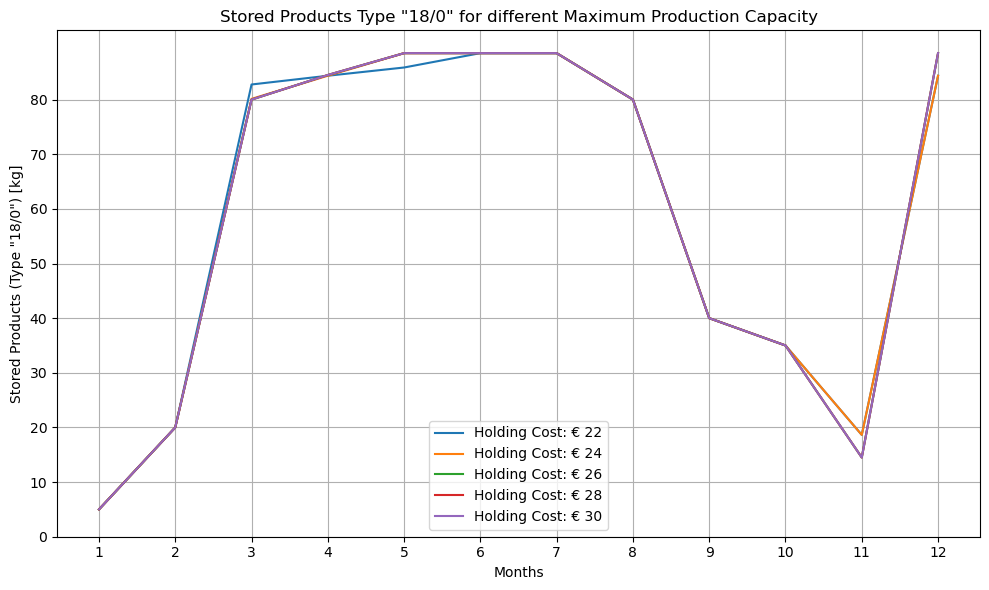

In [16]:
hol_cost_range = range(22, 31, 2)

stored_products_steel = [stored_products(hol_cost) for hol_cost in hol_cost_range]

stored_products_A = [stored_products_steel[i][0] for i in range(len(stored_products_steel))]
stored_products_B = [stored_products_steel[i][1] for i in range(len(stored_products_steel))]
stored_products_C = [stored_products_steel[i][2] for i in range(len(stored_products_steel))]
# print(stored_products_C[i][2])

# print(stored_products_C)

# Plot the results for produced products vs capacity
plt.figure(figsize=(10, 6))
for i, hol_cost in enumerate(hol_cost_range):
    plt.plot(range(1, 13), stored_products_C[i], label=f"Holding Cost: € {hol_cost}")

plt.title('Stored Products Type "18/0" for different Maximum Production Capacity')
plt.xlabel('Months')
plt.ylabel('Stored Products (Type "18/0") [kg]')
plt.xticks(ticks=range(1, 13), labels=[f'{i}' for i in range(1, 13)])
plt.yticks(np.arange(0, max(max(stored_products_C)), 10))  # Adjust max range dynamically based on the data
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig('stored_products_vs_capacity.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 192 rows, 252 columns and 885 nonzeros
Model fingerprint: 0x0a161b52
Coefficient statistics:
  Matrix range     [8e-02, 1e+00]
  Objective range  [5e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 52 rows and 88 columns
Presolve time: 0.02s
Presolved: 140 rows, 164 columns, 667 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.2703040e+03   6.132275e+02   0.000000e+00      0s
      92    1.7628333e+04   0.000000e+00   0.000000e+00      0s

Solved in 92 iterations and 0.03 seconds (0.00 work units)
Optimal objective  1.762833254e+04
Set parameter MIPGap to value 0
Gurobi Optimizer version 11.0.3 build v11.

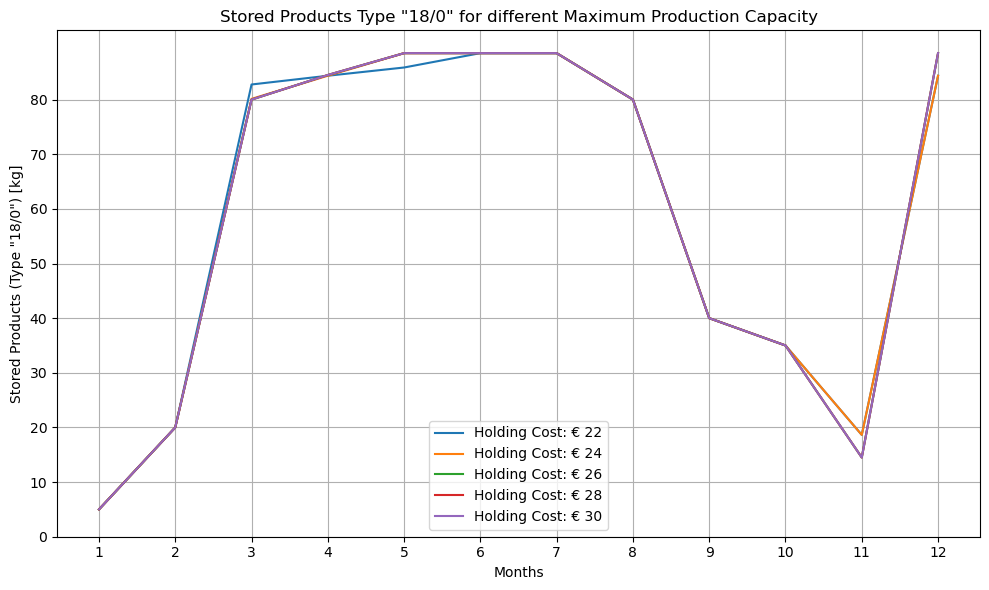

In [17]:
hol_cost_range = range(22, 31, 2)

stored_products_steel = [stored_products(hol_cost) for hol_cost in hol_cost_range]

stored_products_A = [stored_products_steel[i][0] for i in range(len(stored_products_steel))]
stored_products_B = [stored_products_steel[i][1] for i in range(len(stored_products_steel))]
stored_products_C = [stored_products_steel[i][2] for i in range(len(stored_products_steel))]

# Plot the results for produced products vs capacity
plt.figure(figsize=(10, 6))
for i, hol_cost in enumerate(hol_cost_range):
    plt.plot(range(1, 13), stored_products_C[i], label=f"Holding Cost: € {hol_cost}")

plt.title('Stored Products Type "18/0" for different Maximum Production Capacity')
plt.xlabel('Months')
plt.ylabel('Stored Products (Type "18/0") [kg]')
plt.xticks(ticks=range(1, 13), labels=[f'{i}' for i in range(1, 13)])
plt.yticks(np.arange(0, max(max(stored_products_C)), 10))  # Adjust max range dynamically based on the data
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig('stored_products_vs_capacity.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()